# Part 2: Training and Analysis

In this notebook, we begin our training on the features extracted in [Part 1: Feature Extraction](preprocess.ipynb). Three different neural networks are used (separately for now) using [Keras](https://keras.io/), which offers a high-level neural networks API that uses Tensorflow backend.

Recall that due to label imbalance, we will use the following for model evaluation:

* The *f1 score* can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. In the multi-class and multi-label case, this is the weighted average of the F1 score of each class. The formula for the F1 score is 

$$ \text{F1} = 2 \frac{(precision * recall)}{(precision + recall)}. $$

* A *confusion matrix* $C$ is such that $C_{i, j}$ is equal to the number of observations known to be in group i but predicted to be in group j.

* *AUCROC* is the Area Under the Receiver Operating Characteristic Curve. For the multi-class case, this is equivalent to calculating the AUCROC for each label and finding their average, weighted by support (the number of true instances for each label).

These will be observed after training is complete.

## 0. Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers.recurrent import LSTM
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, History
from sklearn.metrics import classification_report, roc_auc_score, zero_one_loss 
from sklearn_evaluation.plot import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


## 1. Training

We start off by loading in all the saved files from the part 1. 

In [2]:
# load saved subsets

datadir = os.path.dirname(os.path.dirname(os.getcwd())) # wherever the train/test sets are stored

X_train_mlp = np.load(os.path.join(datadir, 'X_train_mlp.npy'))
X_test_mlp = np.load(os.path.join(datadir, 'X_test_mlp.npy'))
y_train_mlp = np.load(os.path.join(datadir, 'y_train_mlp.npy'))
y_test_mlp = np.load(os.path.join(datadir, 'y_test_mlp.npy'))

X_train_cnn = np.load(os.path.join(datadir, 'X_train_cnn.npy'))
X_test_cnn = np.load(os.path.join(datadir, 'X_test_cnn.npy'))
y_train_cnn = np.load(os.path.join(datadir, 'y_train_cnn.npy'))
y_test_cnn = np.load(os.path.join(datadir, 'y_test_cnn.npy'))

X_train_rnn = np.load(os.path.join(datadir, 'X_train_rnn.npy'))
X_test_rnn = np.load(os.path.join(datadir, 'X_test_rnn.npy'))
y_train_rnn = np.load(os.path.join(datadir, 'y_train_rnn.npy'))
y_test_rnn = np.load(os.path.join(datadir, 'y_test_rnn.npy'))

print('Data ready')
print("")
print('MLP:')
print('Train set size: {0}'.format(X_train_mlp.shape[0]))
print('Test set size: {0}'.format(X_test_mlp.shape[0]))
print("")
print('CNN:')
print('Train set size: {0}'.format(X_train_cnn.shape[0]))
print('Test set size: {0}'.format(X_test_cnn.shape[0]))
print("")
print('RNN:')
print('Train set size: {0}'.format(X_train_rnn.shape[0]))
print('Test set size: {0}'.format(X_test_rnn.shape[0]))

Data ready

MLP:
Train set size: 3865
Test set size: 1657

CNN:
Train set size: 24943
Test set size: 10691

RNN:
Train set size: 24943
Test set size: 10691


After some quick analysis, the following parameters for the networks were established.

In [3]:
n_labels = y_train_mlp.shape[1]

neur_mlp1 = 500 # neurons in fully-connected layer of mlp
neur_mlp2 = 1000
n_inputs_mlp = X_train_mlp.shape[1]

neur_cnn = 400 # neurons in fully-connected layer of cnn
frames = 41
cnnbands = 60
n_channels = 2
n_inputs_cnn = X_train_cnn.shape[1]*X_train_cnn.shape[2]

rnnbands = 20
n_steps = 41

k = 'TruncatedNormal' # kernel initializer
batch_size = 100
epochs = 1000
lr_mlp = 1e-4
lr_cnn = 1e-4
lr_rnn = 1e-4

A simple architecture with strong regularization is employed. For training, cross entropy with AdamOptimizer is used, given that this is a classification problem with a categorical set of targets. Early stopping is used to provide guidance as to how many iterations can be run before the learners begin to over-fit.

Note that Batch Normalization was placed after non-linearities because that gave the best performance on validation sets.

In [4]:
earlystop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='auto')

### 1.1 MLP

In [5]:
# ignoring userwarnings
warnings.filterwarnings("ignore")

def build_mlp():
    
    model = Sequential()
    model.add(Dense(n_inputs_mlp, input_dim=n_inputs_mlp))
        
    # first fully connected layer
    model.add(Dense(neur_mlp1, kernel_initializer=k, W_regularizer=l2(0.01)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    # second fully connected layer
    model.add(Dense(neur_mlp2, kernel_initializer=k, W_regularizer=l2(0.01)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    # output layer with one node per class
    model.add(Dense(n_labels, kernel_initializer=k))
    model.add(Activation('softmax'))

    # optimization
    adam = Adam(lr=lr_mlp, epsilon=1e-6)
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=adam)
    
    return model

mlp = build_mlp()

mlp.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 186)               34782     
_________________________________________________________________
dense_2 (Dense)              (None, 500)               93500     
_________________________________________________________________
activation_1 (Activation)    (None, 500)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 500)               2000      
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1000)              501000    
_________________________________________________________________
activation_2 (Activation)    (None, 1000)              0         
__________

In [6]:
trained_mlp = mlp.fit(X_train_mlp, 
                      y_train_mlp, 
                      validation_data=(X_test_mlp, y_test_mlp), 
                      callbacks=[earlystop],
                      batch_size=batch_size, 
                      epochs=epochs, 
                      verbose=0)

Epoch 00257: early stopping


In [7]:
sound_names = ["air conditioner","car horn","children playing", "dog bark","drilling",
               "engine idling", "gun shot", "jackhammer","siren","street music"]

# history records training metrics for the models (like loss, accuracy, etc).  
history = History()

# mlp.save('mlp.h5')

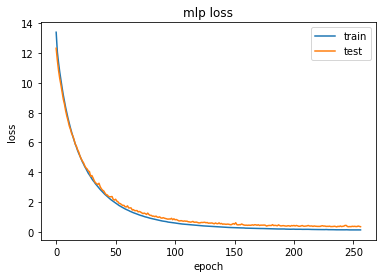

In [8]:
y_prob_mlp = mlp.predict_proba(X_test_mlp, verbose=0)
y_predict_mlp = y_prob_mlp.argmax(axis=-1)

plt.plot(trained_mlp.history['loss'])
plt.plot(trained_mlp.history['val_loss'])
plt.title('mlp loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper right')

                  precision    recall  f1-score   support

 air conditioner       0.92      0.99      0.96       174
        car horn       0.96      0.90      0.93        79
children playing       0.90      0.95      0.92       184
        dog bark       0.96      0.86      0.91       192
        drilling       0.94      0.92      0.93       204
   engine idling       0.99      0.97      0.98       171
        gun shot       1.00      0.98      0.99        65
      jackhammer       0.95      0.96      0.95       166
           siren       0.96      0.99      0.97       216
    street music       0.90      0.90      0.90       206

     avg / total       0.94      0.94      0.94      1657



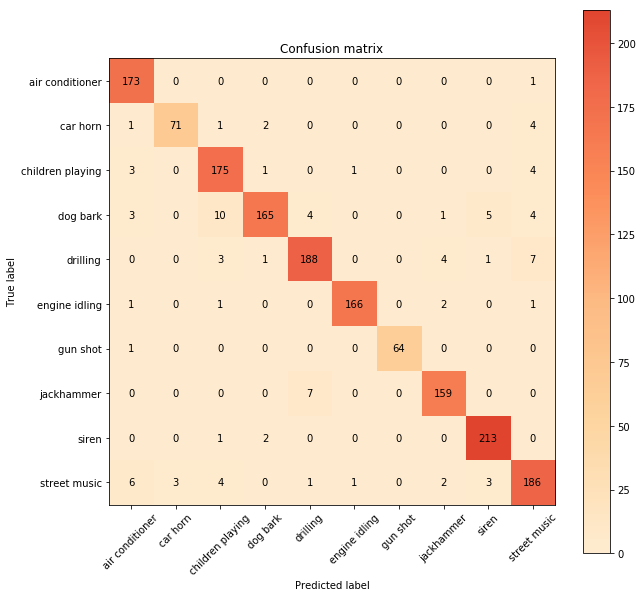

In [9]:
fig = plt.figure(figsize=(10,10))
plt.xticks(rotation=45)
y_true_mlp = np.argmax(y_test_mlp,1)
confusion_matrix(y_true_mlp, y_predict_mlp, sound_names).grid(False)
print(classification_report(y_true_mlp, y_predict_mlp, None, sound_names))

In [10]:
print('AUCROC:', roc_auc_score(y_test_mlp, y_prob_mlp, average='weighted'))
print('Number of misclassifications:', zero_one_loss(y_true_mlp, y_predict_mlp, normalize=False),
      '| Ratio of misclassifications:', zero_one_loss(y_true_mlp, y_predict_mlp, normalize=True))

AUCROC: 0.9952959643798713
Number of misclassifications: 97 | Ratio of misclassifications: 0.05853952926976469


Prominent misclassifications happen between *children playing*, *street music* and *dog bark*. These three also have the lowest f1-scores. One possibility for this misclassification could be that two of the audio clips contain human voices, leading to similar features getting extracted.

### 1.2 CNN

Recall that for the CNN and RNN, feature extraction was done by getting equal-sized segments from the sound clips. The CNN uses the melspecgram with segments of size 60X41 (60 rows/bands and 41 columns/frames), and the RNN uses mfcc of segment size 20X41. These parameters - along with model hyperparameters for the CNN - are either taken directly from or inspired by Karol J. Picak's [Environmental sound classification with convolutional neural networks](http://karol.piczak.com/papers/Piczak2015-ESC-ConvNet.pdf).

In [11]:
def build_cnn():
    
    model = Sequential()
    
    '''
    48 filters: hidden units which take advantage of the local structure present in the input data.
    (4,4) filter size: process a 4x4 block of pixels of the input space.
    Zero-padding: pad the input volume with zeros around the border.
    (2,2) stride: slide the filters over the input space 2x2 pixels at a time.
    Truncated initialization for weights with L2 regularization.
    (2,2) max pooling: downsampling the number of parameters by taking the max of a 2x2 subregion.
    ReLu activation: apply the non-linear function max(0,x) for each input x. 
    Batchnorm: scales the inputs to have zero mean and unit variance.
    '''
    
    model.add(Conv2D(filters=48, 
                     kernel_size=(4,4), 
                     padding='same',
                     strides=(2,2),
                     kernel_initializer=k,
                     kernel_regularizer=l2(0.01),
                     input_shape=(cnnbands, frames, n_channels)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    # next layer has 96 convolution filters
    model.add(Conv2D(filters=96, 
                     kernel_size=(4,4),
                     strides=(2,2),
                     padding='same',
                     kernel_initializer=k,
                     kernel_regularizer=l2(0.01)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Activation('relu'))    
    model.add(BatchNormalization())
    
    # flatten output into a single dimension 
    model.add(Flatten())

    # a FC layer learns non-linear combinations of the features outputted above
    model.add(Dense(neur_cnn, kernel_initializer=k, W_regularizer=l2(0.01)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    # finally the output layer
    model.add(Dense(n_labels, kernel_initializer=k))
    model.add(Activation('softmax'))

    # optmization
    adam = Adam(lr=lr_cnn)
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=adam)
    
    return model

cnn = build_cnn()

cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 21, 48)        1584      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 10, 48)        0         
_________________________________________________________________
activation_4 (Activation)    (None, 15, 10, 48)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 15, 10, 48)        192       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 5, 96)          73824     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 2, 96)          0         
_________________________________________________________________
activation_5 (Activation)    (None, 4, 2, 96)          0         
__________

In [12]:
trained_cnn = cnn.fit(X_train_cnn, 
                      y_train_cnn, 
                      validation_data=(X_test_cnn, y_test_cnn), 
                      callbacks=[earlystop],
                      batch_size=batch_size, 
                      epochs=epochs, 
                      verbose=0)

Epoch 00091: early stopping


In [13]:
# history records training metrics for the models (like loss, accuracy, etc).  
history = History()

# cnn.save('cnn.h5')

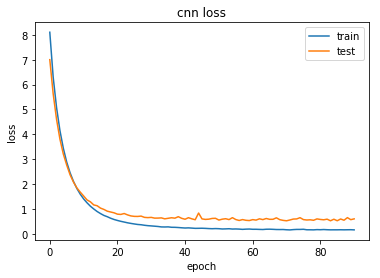

In [14]:
y_prob_cnn = cnn.predict_proba(X_test_cnn, verbose=0)
y_predict_cnn = y_prob_cnn.argmax(axis=-1)

plt.plot(trained_cnn.history['loss'])
plt.plot(trained_cnn.history['val_loss'])
plt.title('cnn loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

                  precision    recall  f1-score   support

 air conditioner       0.90      0.97      0.93      1216
        car horn       0.93      0.94      0.94       473
children playing       0.85      0.64      0.73      1263
        dog bark       0.88      0.84      0.86      1135
        drilling       0.94      0.89      0.92      1314
   engine idling       0.96      0.97      0.97      1175
        gun shot       0.89      0.89      0.89       176
      jackhammer       0.87      0.97      0.92      1005
           siren       0.94      0.97      0.96      1493
    street music       0.78      0.86      0.82      1441

     avg / total       0.89      0.89      0.89     10691



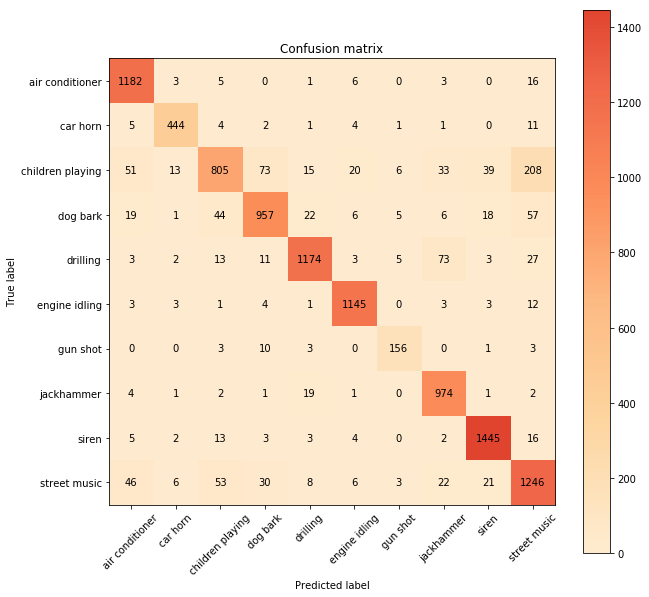

In [15]:
fig = plt.figure(figsize=(10,10))
plt.xticks(rotation=45)
y_true_cnn = np.argmax(y_test_cnn,1)
confusion_matrix(y_true_cnn, y_predict_cnn, sound_names).grid(False)
print(classification_report(y_true_cnn, y_predict_cnn, None, sound_names))

In [16]:
print('AUCROC:', roc_auc_score(y_test_cnn, y_prob_cnn, average='weighted'))
print('Number of misclassifications:', zero_one_loss(y_true_cnn, y_predict_cnn, normalize=False),
      '| Ratio of misclassifications:', zero_one_loss(y_true_cnn, y_predict_cnn, normalize=True))

AUCROC: 0.9905965961448879
Number of misclassifications: 1163 | Ratio of misclassifications: 0.10878308857917873


### 1.3 RNN

In [17]:
def build_rnn():
    
    model = Sequential()
    model.add(LSTM(units=300, # transforms input sequence into a single vector of size 300
                   dropout=0.1, # for input->output
                   recurrent_dropout=0.3, # for time-dependant units
                   return_sequences=True, # many-to-many
                   input_shape=(rnnbands, n_steps)))
    model.add(BatchNormalization())
    model.add(LSTM(units=75, 
                   dropout=0.1, 
                   recurrent_dropout=0.3, 
                   return_sequences=False)) # many-to-one
    model.add(BatchNormalization())
    model.add(Dense(n_labels, 
                    kernel_initializer=k, # truncated normal distribution
                    activation='softmax'))
    
    # optimzation
    adam = Adam(lr=lr_rnn, epsilon=1e-06)
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=adam)
    
    return model

rnn = build_rnn()

rnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20, 300)           410400    
_________________________________________________________________
batch_normalization_6 (Batch (None, 20, 300)           1200      
_________________________________________________________________
lstm_2 (LSTM)                (None, 75)                112800    
_________________________________________________________________
batch_normalization_7 (Batch (None, 75)                300       
_________________________________________________________________
dense_7 (Dense)              (None, 10)                760       
Total params: 525,460
Trainable params: 524,710
Non-trainable params: 750
_________________________________________________________________


In [18]:
trained_rnn = rnn.fit(X_train_rnn, 
                      y_train_rnn, 
                      validation_data=(X_test_rnn, y_test_rnn), 
                      callbacks=[earlystop],
                      batch_size=batch_size, 
                      epochs=epochs, 
                      verbose=0)

Epoch 00219: early stopping


In [19]:
# history records training metrics for the models (like loss, accuracy, etc).  
history = History()

# rnn.save('rnn.h5')

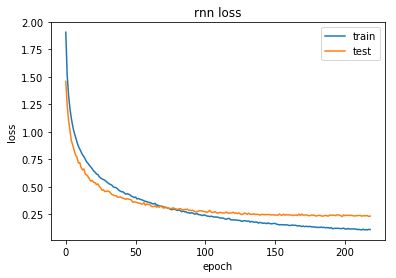

In [20]:
y_prob_rnn = rnn.predict_proba(X_test_rnn, verbose=0)
y_predict_rnn = y_prob_rnn.argmax(axis=-1)

plt.plot(trained_rnn.history['loss'])
plt.plot(trained_rnn.history['val_loss'])
plt.title('rnn loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

                  precision    recall  f1-score   support

 air conditioner       0.97      0.99      0.98      1216
        car horn       0.94      0.96      0.95       473
children playing       0.87      0.87      0.87      1263
        dog bark       0.93      0.86      0.89      1135
        drilling       0.93      0.96      0.94      1314
   engine idling       0.96      0.99      0.97      1175
        gun shot       0.90      0.89      0.90       176
      jackhammer       0.94      0.97      0.96      1005
           siren       0.97      0.98      0.97      1493
    street music       0.90      0.87      0.88      1441

     avg / total       0.93      0.93      0.93     10691



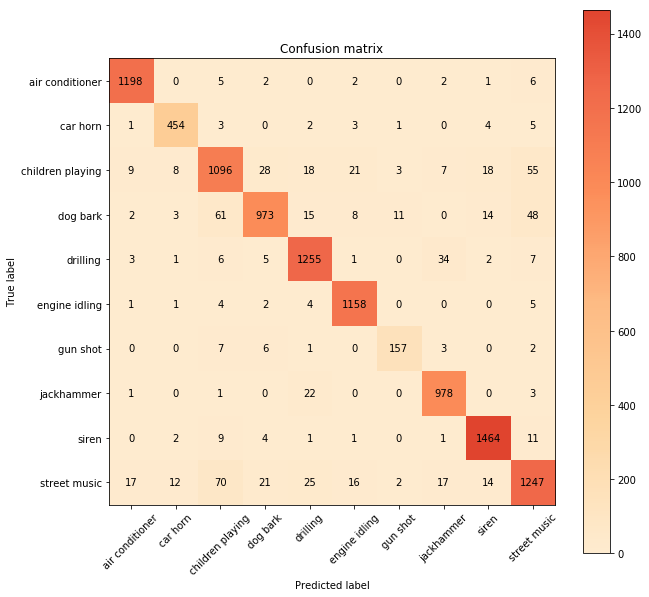

In [21]:
fig = plt.figure(figsize=(10,10))
plt.xticks(rotation=45)
y_true_rnn = np.argmax(y_test_rnn,1)
confusion_matrix(y_true_rnn, y_predict_rnn, sound_names).grid(False)
print(classification_report(y_true_rnn, y_predict_rnn, None, sound_names))

In [22]:
print('AUCROC:', roc_auc_score(y_test_rnn, y_prob_rnn, average='weighted'))
print('Number of misclassifications:', zero_one_loss(y_true_rnn, y_predict_rnn, normalize=False),
      '| Ratio of misclassifications:', zero_one_loss(y_true_rnn, y_predict_rnn, normalize=True))

AUCROC: 0.9963397753380229
Number of misclassifications: 711 | Ratio of misclassifications: 0.06650453652604993


## 2. TCN

One model I'd like to try is the temporal convnet (TCN), based on [An Empirical Evaluation of Generic Convolutional and Recurrent Networks for Sequence Modeling](https://arxiv.org/pdf/1803.01271.pdf).

A TCN is based on two principles:

1) The network produces an output of the same length as the input. This is accomplished by using a **1D fully-convolutional network** architecture, where each hidden layer is the same length as the input layer. 

2) There can be no leakage from the future into the past. This is done by using **causal convolutions**, where an output at time t is convolved only with elements from time t and earlier in the previous layer.

Let's explore this in further detail. A simple causal convolution is only able to look back at a history with size linear in the depth of the network. This makes it hard to apply to sequence tasks with a long history. TCN solves this problem by using **dilated convolutions** which allow for much larger receptive fields.

The authors define this operation as follows. For a 1D input sequence x, and filter f, the dilated convolution F on the sequence element s can be calculated:

$$ F(s) = \sum_{i=0}^{k-1} f(i) * x_{s-d*i}.$$

Here, d is the dilation factor, k is the filter size, and s-di accounts for previous timesteps. See below (a).

<img src="tcn.JPG" alt="Drawing" style="width: 1000px;"/>

For d=1, there is no dilation effect, and we simply get the regular convolution. Subsequent layers having dilations allow them to represent a wider range of inputs, ths expanding (exponentially) the receptive field of the network. 

But the TCN's receptive field still depends on the network depth (along with k and d). For deeper networks, stabilization can be employed using **residual connections**, which can minimize the problem of vanishing grdients. Here's what a typical residual block looks like:

$$ y = A(x + T(x)), $$

where x is the input, y is the output, A is an activation function, and T is a series of transformations to x. This allows layers to learn modifications to the identity mapping rather than the entire transformation, which has shown to benefit very deep networks. Within a residual block, the TCN has two layers of dilated causal convolution and non-linearity. See above (b). 1x1 convolutions ensure that elementwise addition receives tensors of the same shape.